# Grupowanie - pairs + anxiety + depression

# Wczytanie danych:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

#Zbiór danych users
users = pd.read_csv('ausers.csv', delimiter=';')
#print(users.head(50))

In [14]:
anxiety = pd.read_csv('aanxiety.csv', delimiter=';')
print(anxiety.head(5))

duplicates = anxiety.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


In [15]:
depression = pd.read_csv('adepression.csv', delimiter=';')
print(anxiety.head(5))

duplicates = depression.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


# Usuwanie wierszy:

Do usuwania numery wierszy -2 w stosunku do csv
Powtarzające się ID w aanixiety: 
- ID83 - ponad rok różnicy, zostawione oba
- ID76 - -//-
- ID86 - mniej niż godzina różnicy, wywalić wiersz nr 41 (albo 40 bez nagłówka)
- ID82 - ponad rok różnicy, zostawione oba
- ID215 - ponad dzień różnicy, zostawione oba
- ID162 - mniej niż godzina różnicy, wywalić wiersz nr 70 (albo 69 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz nr 93 (92 bez nagłówka)
- ID214 - 22h różnicy??? - zatwierdzone - oba zostawić!!!
- ID129 - kilka dni różnicy, zostawione oba

W adepression: 
Pierwsze dwa tak samo.
ID86 nie istnieje???
- ID82 - mniej niż godzina różnicy, wywalić wiersz nr 36 (albo 35 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz 70

In [16]:
do_usuniecia_anxiety = [39, 68, 91]
do_usuniecia_depression = [34, 68]

anxiety = anxiety.drop(anxiety.index[do_usuniecia_anxiety])
anxiety = anxiety.reset_index(drop=True)

depression = depression.drop(depression.index[do_usuniecia_depression])
depression = depression.reset_index(drop=True)

# Przygotowanie danych: 

In [17]:
# Przygotowanie atrybutów anxiety:
anxiety_split = anxiety['attributes'].str.split('|', expand=True)
anxiety_split.columns = [f'f_{i}' for i in range(anxiety_split.shape[1])]
anxiety = pd.concat([anxiety_split, anxiety['date'], anxiety['email'], anxiety['gender']], axis=1)
print(anxiety.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   3   3   2   3   3   2   0   2   3   0  2021-11-13 14:52  ID13      M
1   2   2   2   1   2   2   0   1   1   1  2021-11-13 14:52  ID48      M
2   3   3   1   2   2   2   2   1   1   1  2021-11-13 15:03   ID6      M
3   2   2   2   2   2   2   1   2   2   2  2021-11-13 15:04   ID5      K
4   1   1   1   1   1   1   0   1   1   2  2021-11-13 15:04  ID34      M


In [18]:
# Przygotowanie atrybutów depression:
d_split = depression['attributes'].str.split('|', expand=True)
d_split.columns = [f'f_{i}' for i in range(d_split.shape[1])]
depression = pd.concat([d_split, depression['date'], depression['email'], depression['gender']], axis=1)
print(depression.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   1   1   0   3   2   1   2   0   2   1  2021-11-13 14:52  ID13      M
1   1   1   1   1   1   0   1   1   0   1  2021-11-13 14:52  ID48      M
2   1   1   0   1   1   1   1   1   1   1  2021-11-13 15:03   ID6      M
3   1   1   1   1   0   1   1   1   1   1  2021-11-13 15:04  ID34      M
4   2   0   0   1   2   2   1   1   2   2  2021-11-13 15:04   ID5      K


In [19]:
featuresA = anxiety.iloc[:,0:10] #cechy do grupowania
featuresA = featuresA.rename(columns=lambda x: f"{x}_a") #Zmiana nazwy, żeby można było rozróżnić cechy
featuresD = depression.iloc[:,0:10] 
featuresD = featuresD.rename(columns=lambda x: f"{x}_d")

all_features = pd.concat([featuresA, featuresD], axis=1)
indexes = []

for i in range(len(all_features)):
    if all_features.iloc[i].isna().any():
        indexes.append(i)
        
all_features = all_features.drop(all_features.index[indexes])    
all_features = all_features.reset_index(drop=True)
print(all_features)

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a f_0_d f_1_d  \
0      3     3     2     3     3     2     0     2     3     0     1     1   
1      2     2     2     1     2     2     0     1     1     1     1     1   
2      3     3     1     2     2     2     2     1     1     1     1     1   
3      2     2     2     2     2     2     1     2     2     2     1     1   
4      1     1     1     1     1     1     0     1     1     2     2     0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
88     1     1     1     1     1     1     0     0     1     1     1     1   
89     1     1     2     1     0     0     0     0     2     1     2     2   
90     2     1     2     1     1     1     1     1     2     2     1     2   
91     2     2     2     2     1     1     1     1     0     1     0     0   
92     3     1     2     1     1     1     1     2     1     2     2     2   

   f_2_d f_3_d f_4_d f_5_d f_6_d f_7_d f_8_d f_9_d  
0      0  

In [20]:
print(users)

     birth_year  child_number doughter_birth_years education  email gender  \
0          1981             3            2009,2015    wyższe    ID1      M   
1          1984             3            2009,2015    wyższe    ID2      K   
2          1991             0                  NaN    wyższe    ID3      K   
3          1988             0                  NaN    wyższe    ID4      M   
4          1984             0                  NaN    wyższe    ID5      K   
..          ...           ...                  ...       ...    ...    ...   
279        1974             6       1999,2000,2007    wyższe  ID280      M   
280        1990             0                  NaN    wyższe  ID281      K   
281        1989             0                  NaN   średnie  ID282      M   
282        1985             2            2019,2021    wyższe  ID283      K   
283        1986             2            2019,2021   średnie  ID284      M   

     mariage_year partner_email  relation_start_year son_birth_

In [21]:
#Czy klasyfikować ich jako pojedyncze osoby, ale z partnerem, czy jako pary. 
#Bo jeśli  jako pary, to płeć można całkiem usunąć, skoro obie osoby są brane pod uwagę
#Ale jeśli jako pary, to czyją chorobę mamy na myśli. Chyba, że chodzi tylko o sam fakt jej istnienia
#Więc chyba można wziąć pod uwagę pojedyncze osoby, ale z uwzględnieniem wieku i edukacji ich partnera, żeby klasyfikować ich zdrowie psychiczne 
# w zależności od ich relacji

Birth year - zamienić na wiek i uwzględnić wiek najmłodszego dziecka, średnia wieku i ile jest synów i córek

In [31]:
from pandas.api.types import CategoricalDtype
from datetime import datetime
current_year = datetime.now().year #Bieżący rok

single_ad = users.copy()

#------------------------------------------------------------------------------
do_usuniecia = []
single_ad['partner_education'] = None
single_ad['partner_age'] = None

for i in range(len(single_ad)):
    #if single_ad['gender'].iloc[i] == "M":
    id = single_ad['email']
    partner = single_ad['partner_email'].iloc[i]
    znaleziono_partnera = False
    for j in range(len(single_ad)):
        if single_ad['email'].iloc[j] == partner:
            znalezniono_partnera = True
            partner_wiek = current_year - single_ad['birth_year'].iloc[j]
            partner_edukacja = single_ad['education'].iloc[j]
    if znaleziono_partnera == False:
        single_ad['partner_education'].iloc[i] = partner_edukacja
        single_ad['partner_age'].iloc[i] = partner_wiek
    else:
        do_usuniecia.append(i)

single_ad = single_ad.drop(single_ad.index[do_usuniecia]).reset_index(drop=True) #Jak nie znaleziono partnera, to nie ma sensu klasyfikować tej osoby w tym zestawieniu
#------------------------------------------------------------------------------

#Eliminowanie NaN
for i in range(len(single_ad)):
    if pd.isna(single_ad['doughter_birth_years'].iloc[i]): 
        single_ad.loc[i, 'doughter_birth_years'] = "0"
    if pd.isna(single_ad['son_birth_years'].iloc[i]):
        single_ad.loc[i, 'son_birth_years'] = "0"

#Ilość synów i córek
single_ad['no_of_daughters'] = single_ad['doughter_birth_years'].apply(
    lambda x: 0 if x == '0' else len(x.split(','))
)
single_ad['no_of_sons'] = single_ad['son_birth_years'].apply(
    lambda x: 0 if x == '0' else len(x.split(','))
)
#Wiek najmłodszego dziecka
single_ad['child_birth_years'] = single_ad['doughter_birth_years'].fillna('') + ',' + single_ad['son_birth_years'].fillna('')
single_ad['child_birth_years'] = single_ad['child_birth_years'].str.strip(',')
single_ad['age_oldest_child'] = current_year - single_ad['child_birth_years'].apply(lambda x: max(map(int, x.split(','))))
single_ad['age_oldest_child'] = single_ad['age_oldest_child'].apply(
    lambda x: 0 if x == current_year else x
)
#Średnia wieku dzieci
def calculate_average_years(date_string):
    years = date_string.split(',')  # Daty rozdzielone przecinkami
    age_differences = [current_year - int(year.strip()) for year in years if year.strip().isdigit() and year != '0']
    return round(sum(age_differences) / len(age_differences)) if age_differences else 0

single_ad['average_child_age'] = single_ad['child_birth_years'].apply(calculate_average_years).apply(
    lambda x: 0 if x == current_year else x
)

#Edukacja
education_order = CategoricalDtype(categories=['średnie', 'wyższe'], ordered=True) #0 - średnie, 1 - wyższe
single_ad['education'] = single_ad['education'].astype(education_order)
single_ad['education'] = single_ad['education'].cat.codes
single_ad['partner_education'] = single_ad['partner_education'].astype(education_order)
single_ad['partner_education'] = single_ad['partner_education'].cat.codes

# Mapowanie płci na liczby
gender_mapping = {'K': 0, 'M': 1}
single_ad['gender'] = single_ad['gender'].map(gender_mapping)

# Kolumna rok urodzenia - zamiana na wiek
single_ad['age'] = current_year - single_ad['birth_year'] #Tworzenie nowej kolumny z wiekiem
single_ad['years_of_mariage'] = current_year - single_ad['mariage_year'] #Kolumna ze stażem małżeństwa
single_ad['years_of_relationship'] = current_year - single_ad['relation_start_year'] #Kolumna ze stażem związku


#Usuwanie niepotrzebnych do grupowania kolumn
single_ad = single_ad.drop(columns=['birth_year','email','partner_email','doughter_birth_years','son_birth_years','child_birth_years','mariage_year','relation_start_year'])

print(single_ad)

     child_number  education  gender  partner_education partner_age  \
0               3          1       1                  1          41   
1               3          1       0                  1          44   
2               0          1       0                  1          37   
3               0          1       1                  1          34   
4               0          1       0                  1          45   
..            ...        ...     ...                ...         ...   
279             6          1       1                  1          49   
280             0          1       0                  0          36   
281             0          0       1                  1          35   
282             2          1       0                  0          39   
283             2          0       1                  1          40   

     no_of_daughters  no_of_sons  age_oldest_child  average_child_age  age  \
0                  2           1                10                 13

C:\Users\Admin\AppData\Local\Temp\ipykernel_26020\2729139368.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  single_ad['partner_education'].iloc[i] = partner_edukacja
C:\Users\Admin\AppData\Local\Temp\ipykernel_26020\2729139368.py:23: S

In [32]:
single_ad = pd.concat([all_features, single_ad], axis = 1) #data frame z danymi dot. anxiety i depression dla pojedynczych użytkowników plus partnerzy
#print(single_ad)

indexes = []
    
for i in range(len(single_ad)):    
    if single_ad.iloc[i].isna().any():
        indexes.append(i)
        
single_ad = single_ad.drop(single_ad.index[indexes])    
single_ad = single_ad.reset_index(drop=True)
print(single_ad)

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a  ... gender  \
0      3     3     2     3     3     2     0     2     3     0  ...      1   
1      2     2     2     1     2     2     0     1     1     1  ...      0   
2      3     3     1     2     2     2     2     1     1     1  ...      0   
3      2     2     2     2     2     2     1     2     2     2  ...      1   
4      1     1     1     1     1     1     0     1     1     2  ...      0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
88     1     1     1     1     1     1     0     0     1     1  ...      1   
89     1     1     2     1     0     0     0     0     2     1  ...      0   
90     2     1     2     1     1     1     1     1     2     2  ...      1   
91     2     2     2     2     1     1     1     1     0     1  ...      0   
92     3     1     2     1     1     1     1     2     1     2  ...      1   

   partner_education partner_age no_of_daughters no_of_sons age

# Grupowanie KMeans

In [33]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(single_ad) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(single_ad)

Miara jakości =  20456.920634920636
Centroidy: 
 [[ 1.66666667  1.16666667  1.5         1.13333333  0.93333333  1.03333333
   0.46666667  1.23333333  1.2         1.1         0.66666667  0.9
   0.76666667  1.5         1.06666667  0.86666667  1.13333333  0.7
   1.          0.8         3.46666667  0.7         0.5         0.7
  55.          1.53333333  1.93333333 18.6        24.33333333 55.
  30.13333333 33.        ]
 [ 1.82539683  1.14285714  1.38095238  1.36507937  1.07936508  1.01587302
   0.34920635  1.33333333  1.19047619  1.14285714  0.76190476  0.77777778
   0.74603175  1.52380952  1.12698413  0.71428571  0.98412698  0.74603175
   1.06349206  1.04761905  2.14285714  0.77777778  0.49206349  0.77777778
  41.38095238  1.0952381   1.04761905  7.49206349  9.68253968 41.28571429
  13.76190476 16.07936508]]


In [34]:
#Dla 3 klastrów
kmeans3 = KMeans(n_clusters=3, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans3.fit(single_ad) #Grupowanie

inertia3 = kmeans3.inertia_
print("Miara jakości = ", inertia3);

centroids3 = kmeans3.cluster_centers_
print("Centroidy: \n", centroids3)

clusters3 = kmeans3.fit_predict(single_ad)

Miara jakości =  12277.801041981276
Centroidy: 
 [[ 1.67857143  1.21428571  1.53571429  1.14285714  1.          1.03571429
   0.5         1.28571429  1.21428571  1.14285714  0.67857143  0.82142857
   0.78571429  1.5         1.03571429  0.92857143  1.14285714  0.67857143
   1.          0.78571429  3.57142857  0.67857143  0.5         0.67857143
  55.39285714  1.57142857  2.         18.78571429 24.71428571 55.39285714
  30.57142857 33.64285714]
 [ 1.86363636  1.13636364  1.40909091  1.45454545  1.          1.09090909
   0.31818182  1.54545455  1.22727273  1.18181818  0.77272727  0.68181818
   0.5         1.40909091  1.          0.72727273  0.77272727  0.59090909
   1.          0.90909091  0.81818182  0.68181818  0.5         0.68181818
  34.63636364  0.63636364  0.18181818  3.45454545  4.         34.63636364
   7.          8.90909091]
 [ 1.79069767  1.11627907  1.34883721  1.30232558  1.06976744  0.97674419
   0.34883721  1.18604651  1.1627907   1.09302326  0.74418605  0.88372093
   0.8604

# Optymalizacja skupień metodą łokcia

*** Eksperyment numer: 1 Jakość =  46245.20430107526
*** Eksperyment numer: 2 Jakość =  20456.920634920636
*** Eksperyment numer: 3 Jakość =  12277.801041981276
*** Eksperyment numer: 4 Jakość =  9817.363408521305
*** Eksperyment numer: 5 Jakość =  8038.337362637363
*** Eksperyment numer: 6 Jakość =  6698.5557800751885
*** Eksperyment numer: 7 Jakość =  5785.16173245614
*** Eksperyment numer: 8 Jakość =  5007.5958646616555
*** Eksperyment numer: 9 Jakość =  4759.3210317460325


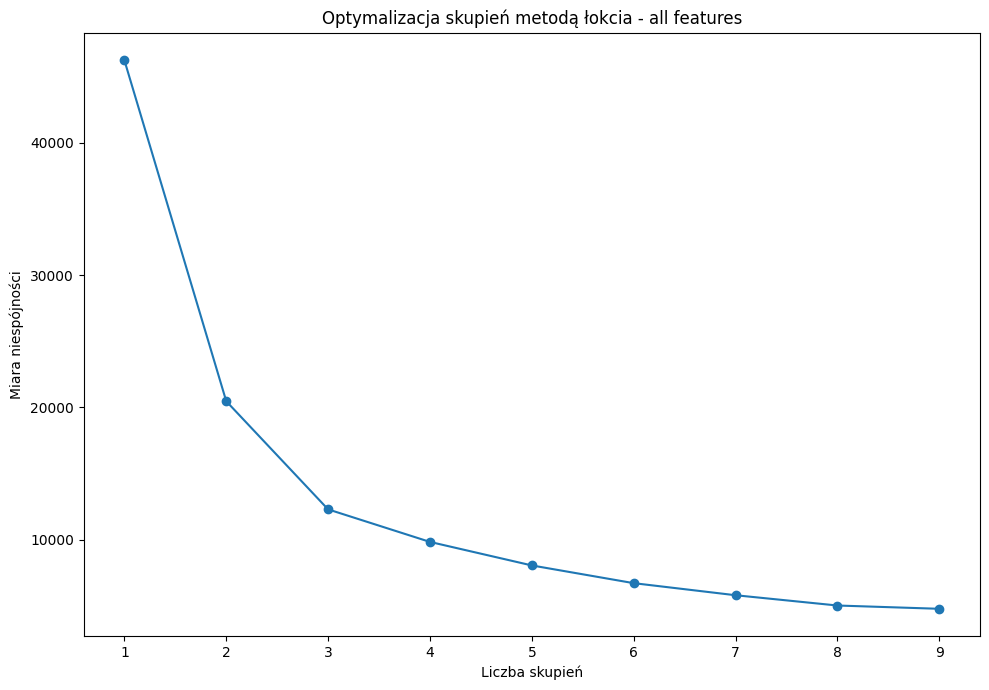

In [35]:
results = []
n = 10 #Liczba eksperymentów
for k in range(1, n):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(single_ad)
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = kmeans.inertia_ #Powinna być jak najmniejsza
    
    results.append(inertia)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia 

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,n), results , marker='o')
plt.title("Optymalizacja skupień metodą łokcia - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()

# Miara Silhouette

In [36]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(single_ad, clusters)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: {silhouette_avg:.3f}")

silhouette_avg3 = silhouette_score(single_ad, clusters3)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: {silhouette_avg3:.3f}")

Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: 0.466
Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: 0.415


*** Eksperyment numer: 2 Jakość =  0.4657112680750465
*** Eksperyment numer: 3 Jakość =  0.4148295201735241
*** Eksperyment numer: 4 Jakość =  0.326936649708122
*** Eksperyment numer: 5 Jakość =  0.3616434493694482
*** Eksperyment numer: 6 Jakość =  0.3272389104073771
*** Eksperyment numer: 7 Jakość =  0.3516176954214536
*** Eksperyment numer: 8 Jakość =  0.32397434805157826
*** Eksperyment numer: 9 Jakość =  0.3268708864070071


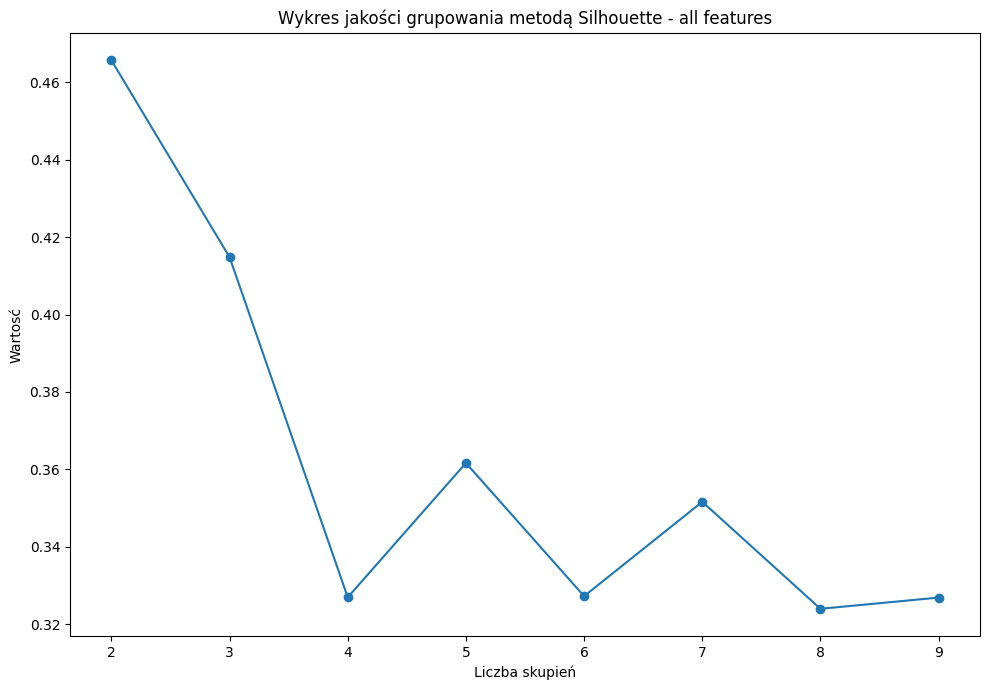

In [37]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    silhouette_avg = silhouette_score(single_ad, clusters) #Powinna być jak najbliższa 1, ale broń Boże nie poniżej 0
    results.append(silhouette_avg)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", silhouette_avg)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania metodą Silhouette - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Indeks Davies - Bouldin

In [38]:
# Obliczenie indeksu Davies-Bouldin
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(single_ad, clusters)
print(f"Indeks Davies-Bouldin, liczba skupień 2: {dbi:.3f}")

dbi3 = davies_bouldin_score(single_ad, clusters3)
print(f"Indeks Davies-Bouldin, liczba skupień 3: {dbi3:.3f}")

Indeks Davies-Bouldin, liczba skupień 2: 0.952
Indeks Davies-Bouldin, liczba skupień 3: 0.820


*** Eksperyment numer: 2 Jakość =  0.7261530994076193
*** Eksperyment numer: 3 Jakość =  0.8196628629388724
*** Eksperyment numer: 4 Jakość =  0.9233179959286397
*** Eksperyment numer: 5 Jakość =  0.8658113127859913
*** Eksperyment numer: 6 Jakość =  0.9479309841492486
*** Eksperyment numer: 7 Jakość =  0.8333957650068344
*** Eksperyment numer: 8 Jakość =  0.9945662001831319
*** Eksperyment numer: 9 Jakość =  0.9524474735784353


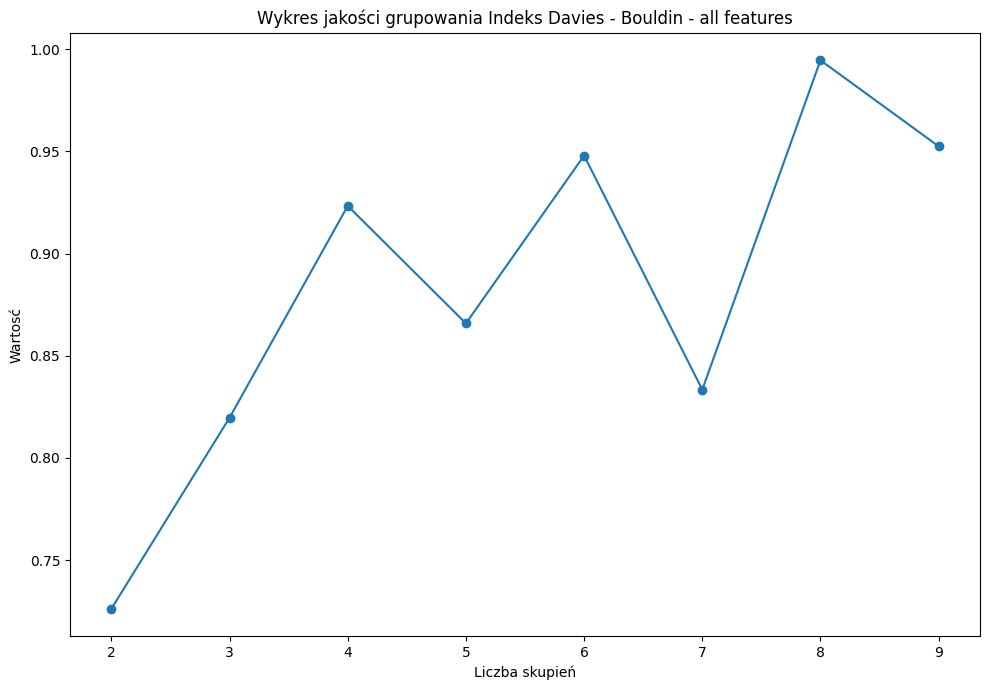

In [39]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    dbi = davies_bouldin_score(single_ad, clusters)
    results.append(dbi)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", dbi)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania Indeks Davies - Bouldin - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Miara Calinski-Harabasz

In [40]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(single_ad, clusters)
print("Calinski-Harabasz score, liczba skupień 2:", ch_score)

ch_score3 = calinski_harabasz_score(single_ad, clusters3)
print("Calinski-Harabasz score, liczba skupień 3:", ch_score3)

Calinski-Harabasz score, liczba skupień 2: 91.52603310900203
Calinski-Harabasz score, liczba skupień 3: 124.49567650043709


*** Eksperyment numer: 2 Jakość =  114.71588786506413
*** Eksperyment numer: 3 Jakość =  124.49567650043709
*** Eksperyment numer: 4 Jakość =  110.07971979602436
*** Eksperyment numer: 5 Jakość =  104.5677774800249
*** Eksperyment numer: 6 Jakość =  102.72537944853505
*** Eksperyment numer: 7 Jakość =  100.24391773929906
*** Eksperyment numer: 8 Jakość =  99.99656555557213
*** Eksperyment numer: 9 Jakość =  91.52603310900203


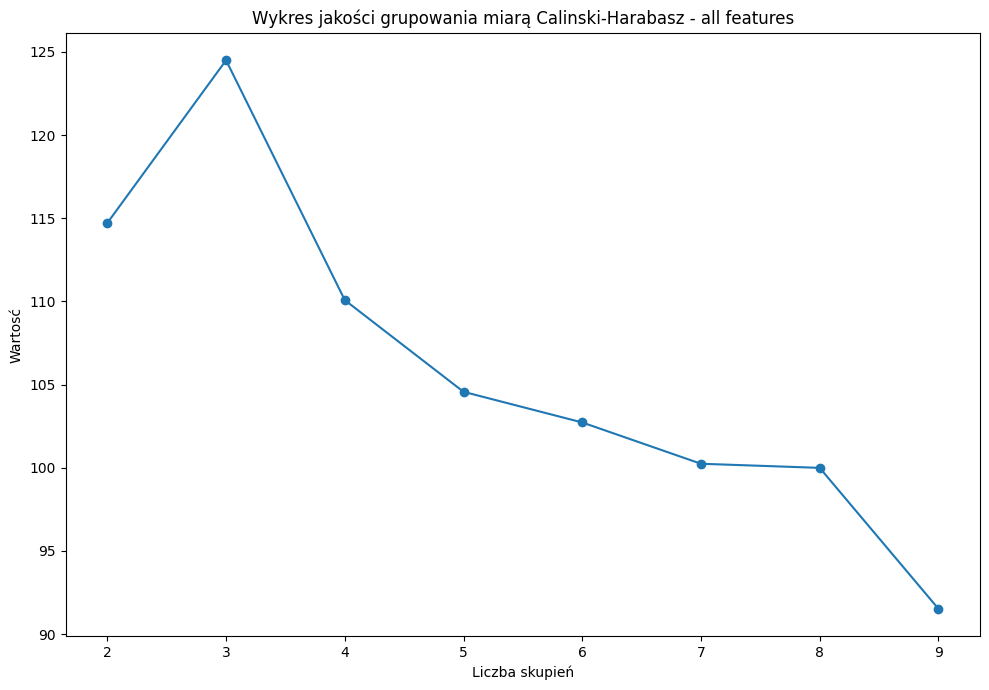

In [41]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    ch_score = calinski_harabasz_score(single_ad, clusters)
    results.append(ch_score)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", ch_score)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania miarą Calinski-Harabasz - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Wizualizacja skupień 
Metoda PCA

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


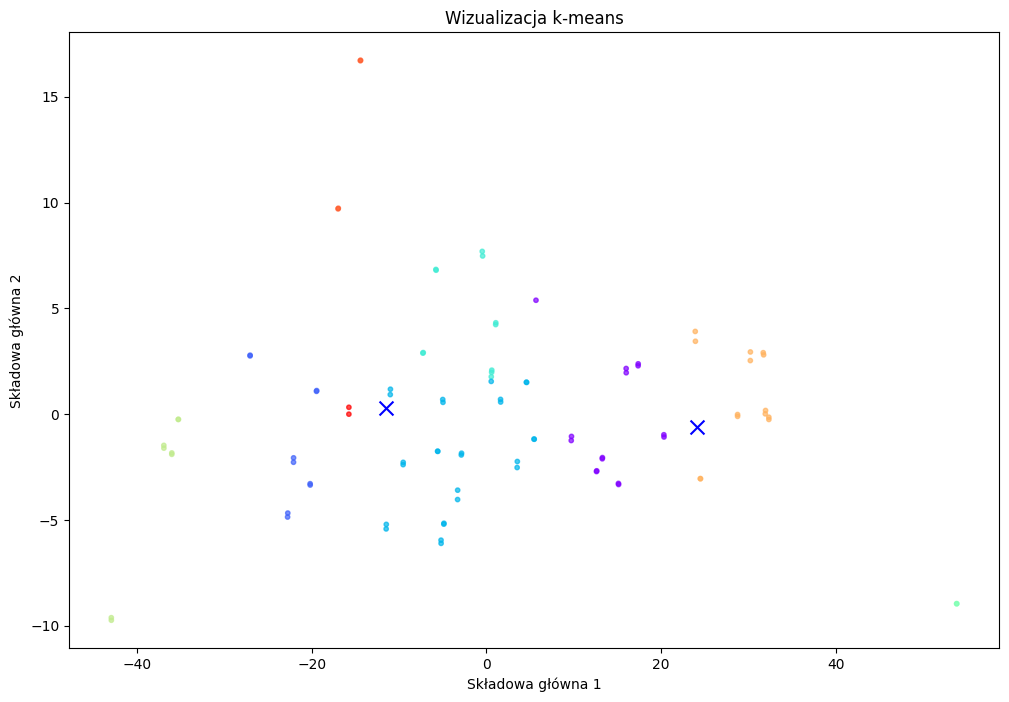

In [42]:
clusters = kmeans.fit_predict(single_ad)

#Redukcja wymiarów za pomocą PCA - dane są sprowadzane do 2 wymiarów
pca = PCA(n_components=2)
features_pca = pca.fit_transform(single_ad)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja k-means')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='rainbow', s=10, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, color='blue', marker='x')
plt.xlabel('Składowa główna 1')
plt.ylabel('Składowa główna 2')
plt.show()

# Grupowanie metodą hierarchiczną

In [43]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
ac.fit(single_ad)

print(len(single_ad))

clustersHierarchy = ac.fit_predict(single_ad)

for i in range(0,len(clusters)):
    print("Obiekt numer:"+str(i)," Skupienie:"+str(clustersHierarchy[i]))

93
Obiekt numer:0  Skupienie:1
Obiekt numer:1  Skupienie:1
Obiekt numer:2  Skupienie:1
Obiekt numer:3  Skupienie:1
Obiekt numer:4  Skupienie:1
Obiekt numer:5  Skupienie:1
Obiekt numer:6  Skupienie:0
Obiekt numer:7  Skupienie:0
Obiekt numer:8  Skupienie:0
Obiekt numer:9  Skupienie:1
Obiekt numer:10  Skupienie:1
Obiekt numer:11  Skupienie:0
Obiekt numer:12  Skupienie:0
Obiekt numer:13  Skupienie:0
Obiekt numer:14  Skupienie:1
Obiekt numer:15  Skupienie:0
Obiekt numer:16  Skupienie:0
Obiekt numer:17  Skupienie:0
Obiekt numer:18  Skupienie:1
Obiekt numer:19  Skupienie:1
Obiekt numer:20  Skupienie:0
Obiekt numer:21  Skupienie:0
Obiekt numer:22  Skupienie:1
Obiekt numer:23  Skupienie:1
Obiekt numer:24  Skupienie:1
Obiekt numer:25  Skupienie:1
Obiekt numer:26  Skupienie:1
Obiekt numer:27  Skupienie:1
Obiekt numer:28  Skupienie:1
Obiekt numer:29  Skupienie:1
Obiekt numer:30  Skupienie:1
Obiekt numer:31  Skupienie:1
Obiekt numer:32  Skupienie:1
Obiekt numer:33  Skupienie:1
Obiekt numer:34  Skup

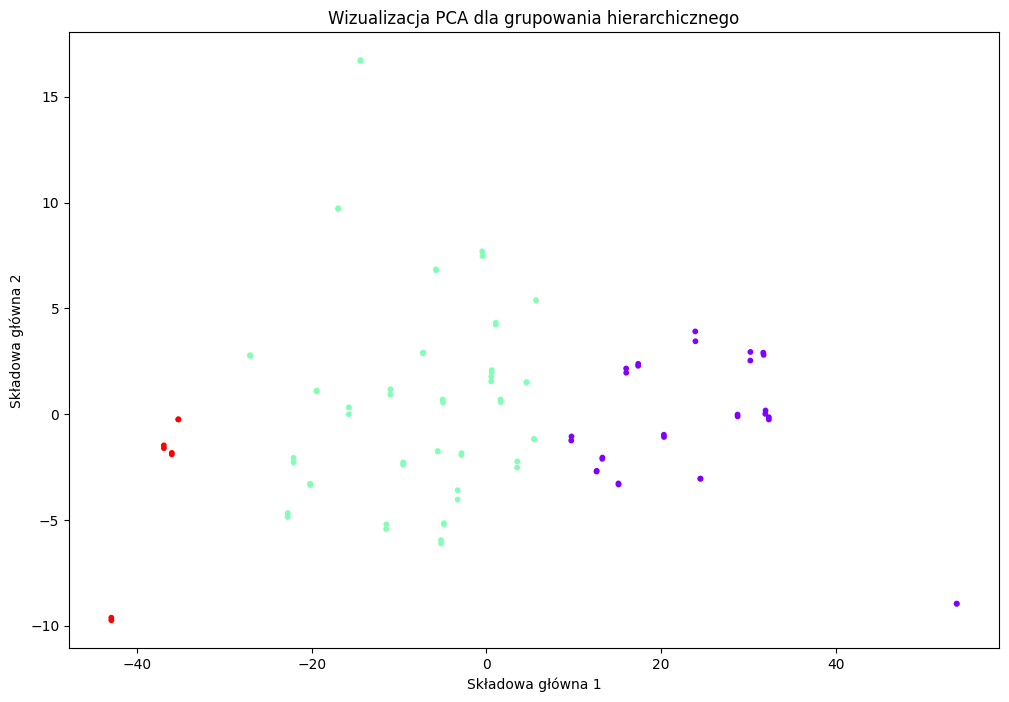

In [44]:
#Anxiety
# Redukcja wymiarów za pomocą PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(single_ad)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja PCA dla grupowania hierarchicznego')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersHierarchy, s=10, alpha=0.99, cmap='rainbow')
plt.xlabel("Składowa główna 1")
plt.ylabel("Składowa główna 2")
plt.show()

# Właściwe grupowanie 

In [52]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(single_ad) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(single_ad)

Miara jakości =  20456.920634920636
Centroidy: 
 [[ 1.66666667  1.16666667  1.5         1.13333333  0.93333333  1.03333333
   0.46666667  1.23333333  1.2         1.1         0.66666667  0.9
   0.76666667  1.5         1.06666667  0.86666667  1.13333333  0.7
   1.          0.8         3.46666667  0.7         0.5         0.7
  55.          1.53333333  1.93333333 18.6        24.33333333 55.
  30.13333333 33.        ]
 [ 1.82539683  1.14285714  1.38095238  1.36507937  1.07936508  1.01587302
   0.34920635  1.33333333  1.19047619  1.14285714  0.76190476  0.77777778
   0.74603175  1.52380952  1.12698413  0.71428571  0.98412698  0.74603175
   1.06349206  1.04761905  2.14285714  0.77777778  0.49206349  0.77777778
  41.38095238  1.0952381   1.04761905  7.49206349  9.68253968 41.28571429
  13.76190476 16.07936508]]


# Przypisanie grup do danych

In [53]:
# Przypisanie grup do danych - all_features
allGroups = single_ad.copy()
new_column = pd.Series(clusters, name='group')
allGroups = pd.concat([allGroups, new_column], axis=1)

#print(allGroups.head(10))

#Zestawienie wszystkich grup z wszystkimi
wiersze = []

for i in range(0,len(allGroups)-1):
    for j in range(0,len(allGroups)-1):
        if i != j:
            index_i = pd.Series(allGroups.index[i], index=['index_i'])
            features_i = allGroups.iloc[i,0:20].reset_index(drop=True)
            features_i.index = [f'feature_{k}_i' for k in range(0,len(features_i))]
            group_i = pd.Series(allGroups.iloc[i,32], index=['group_i'])
            index_j = pd.Series(allGroups.index[j], index=['index_j'])
            features_j = allGroups.iloc[j,0:20].reset_index(drop=True)
            features_j.index = [f'feature_{k}_j' for k in range(0,len(features_j))]
            group_j = pd.Series(allGroups.iloc[j,32], index=['group_j'])
            wiersz = pd.concat([features_i, features_j, index_i , group_i, index_j, group_j], axis=0)
            wiersze.append(wiersz)

allFeaturesZestawienie = pd.DataFrame(wiersze)
print(allFeaturesZestawienie.tail())

     feature_0_i feature_1_i feature_2_i feature_3_i feature_4_i feature_5_i  \
8367           2           2           2           2           1           1   
8368           2           2           2           2           1           1   
8369           2           2           2           2           1           1   
8370           2           2           2           2           1           1   
8371           2           2           2           2           1           1   

     feature_6_i feature_7_i feature_8_i feature_9_i  ... feature_14_j  \
8367           1           1           0           1  ...            1   
8368           1           1           0           1  ...            0   
8369           1           1           0           1  ...            1   
8370           1           1           0           1  ...            2   
8371           1           1           0           1  ...            2   

     feature_15_j feature_16_j feature_17_j feature_18_j feature_19_j inde

# Reguły decyzyjne

In [54]:
# Reguły decyzyjne
allFeaturesRules = allFeaturesZestawienie.copy()

#Zestawienie wszystkich grup z wszystkimi
rows = []

for i in range(0,len(allFeaturesRules)):
    row = allFeaturesRules.iloc[i]
    if int(row['group_i']) != int(row['group_j']): #wykluczenie wierszy, w których nie ma zmiany grupy
        wiersz = {
            'feature_0_a': f"\"{row['feature_0_i']}-{row['feature_0_j']}\"",
            'feature_1_a': f"\"{row['feature_1_i']}-{row['feature_1_j']}\"",
            'feature_2_a': f"\"{row['feature_2_i']}-{row['feature_2_j']}\"",
            'feature_3_a': f"\"{row['feature_3_i']}-{row['feature_3_j']}\"",
            'feature_4_a': f"\"{row['feature_4_i']}-{row['feature_4_j']}\"",
            'feature_5_a': f"\"{row['feature_5_i']}-{row['feature_5_j']}\"",
            'feature_6_a': f"\"{row['feature_6_i']}-{row['feature_6_j']}\"",
            'feature_7_a': f"\"{row['feature_7_i']}-{row['feature_7_j']}\"",
            'feature_8_a': f"\"{row['feature_8_i']}-{row['feature_8_j']}\"",
            'feature_9_a': f"\"{row['feature_9_i']}-{row['feature_9_j']}\"",
            'feature_0_d': f"\"{row['feature_10_i']}-{row['feature_10_j']}\"",
            'feature_1_d': f"\"{row['feature_11_i']}-{row['feature_11_j']}\"",
            'feature_2_d': f"\"{row['feature_12_i']}-{row['feature_12_j']}\"",
            'feature_3_d': f"\"{row['feature_13_i']}-{row['feature_13_j']}\"",
            'feature_4_d': f"\"{row['feature_14_i']}-{row['feature_14_j']}\"",
            'feature_5_d': f"\"{row['feature_15_i']}-{row['feature_15_j']}\"",
            'feature_6_d': f"\"{row['feature_16_i']}-{row['feature_16_j']}\"",
            'feature_7_d': f"\"{row['feature_17_i']}-{row['feature_17_j']}\"",
            'feature_8_d': f"\"{row['feature_18_i']}-{row['feature_18_j']}\"",
            'feature_9_d': f"\"{row['feature_19_i']}-{row['feature_19_j']}\"",
            'group': f"\"{row['group_i']}-{row['group_j']}\""
        }
        rows.append(wiersz)

allFeaturesRules = pd.DataFrame(rows)
print(allFeaturesRules)

     feature_0_a feature_1_a feature_2_a feature_3_a feature_4_a feature_5_a  \
0          "3-2"       "3-2"       "2-1"       "3-1"       "3-1"       "2-1"   
1          "3-1"       "3-0"       "2-1"       "3-0"       "3-0"       "2-1"   
2          "3-2"       "3-2"       "2-2"       "3-1"       "3-2"       "2-1"   
3          "3-3"       "3-3"       "2-3"       "3-2"       "3-3"       "2-3"   
4          "3-1"       "3-1"       "2-1"       "3-1"       "3-1"       "2-1"   
...          ...         ...         ...         ...         ...         ...   
3715       "2-2"       "2-2"       "2-2"       "2-1"       "1-2"       "1-1"   
3716       "2-2"       "2-2"       "2-3"       "2-2"       "1-2"       "1-2"   
3717       "2-1"       "2-0"       "2-0"       "2-0"       "1-1"       "1-0"   
3718       "2-1"       "2-1"       "2-1"       "2-0"       "1-0"       "1-1"   
3719       "2-1"       "2-0"       "2-1"       "2-0"       "1-1"       "1-0"   

     feature_6_a feature_7_a feature_8_

# Eksport do formatu RSES

In [50]:
# Funkcja do eksportu DataFrame do formatu RSES
def export_to_tab(df, attributes_info, table_name, filename):
    """
    Eksportuje DataFrame do pliku w formacie tabelarycznym (tab).
    
    :param df: Pandas DataFrame z danymi.
    :param attributes_info: Lista krotek (nazwa_atrybutu, typ, [precision]).
    :param table_name: Nazwa tabeli.
    :param filename: Nazwa pliku wyjściowego.
    """
    with open(filename, 'w') as f:
        # Nagłówek
        f.write(f'TABLE "{table_name}"\n')
        f.write(f'ATTRIBUTES {len(attributes_info)}\n')
        for attr in attributes_info:
            line = f' {attr[0]} {attr[1]}'
            if len(attr) > 2:  # Jeśli podano precyzję
                line += f' {attr[2]}'
            f.write(line + '\n')
        f.write(f'OBJECTS {len(df)}\n')
        
        # Dane obiektów
        for _, row in df.iterrows():
            f.write(" ".join(map(str, row.values)) + '\n')

    print(f"Eksport zakończony. Plik został zapisany jako {filename}.")

In [55]:
attributes_info = [
    ("f_0_a","symbolic"),
    ("f_1_a","symbolic"),
    ("f_2_a","symbolic"),
    ("f_3_a","symbolic"),
    ("f_4_a","symbolic"),
    ("f_5_a","symbolic"),
    ("f_6_a","symbolic"),
    ("f_7_a","symbolic"),
    ("f_8_a","symbolic"),
    ("f_9_a","symbolic"),
    ("f_0_d","symbolic"),
    ("f_1_d","symbolic"),
    ("f_2_d","symbolic"),
    ("f_3_d","symbolic"),
    ("f_4_d","symbolic"),
    ("f_5_d","symbolic"),
    ("f_6_d","symbolic"),
    ("f_7_d","symbolic"),
    ("f_8_d","symbolic"),
    ("f_9_d","symbolic"),
    ("group","symbolic"),
]

# Eksport danych do pliku tab
export_to_tab(allFeaturesRules, attributes_info, table_name="all_features_plus_paired_user", filename="all_features_plus_paired_user_2_rules.tab")

Eksport zakończony. Plik został zapisany jako all_features_plus_paired_user_2_rules.tab.
